# Tree shape diversity

### The plot elements below will be saved to `/analysis/output/NDS-LB/`

In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm, SymLogNorm

## Load GC trees and constuct a data frame of statistics

In [2]:
results = "../nextflow/results/latest"

In [20]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), f"{PR_str[3]}-{PR_str[2]}"

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    mouse, gc = gc_key(file)
    # 20 day only
    # if mouse not in range(6 + 1):
    #     continue
    trees[f"mouse{mouse}_GC{gc}"] = pickle.load(open(file, "rb"))


print(f"loaded {len(trees)} GC trees")

loaded 95 GC trees


GVI decay factor

In [21]:
tau = 0.75

In [46]:
df = pd.DataFrame()

for row, (mouse_gc, tree) in enumerate(trees.items()):
    mouse, gc = mouse_gc.split("_")
    mouse = mouse.lstrip("mouse")
    
    # polytomy degree as simple branching metric
    # Duncan's local branching fraction (LBF)
    # Gabriel's good variant index GVI
    total_length = sum(node.dist for node in tree.tree.traverse())
    total_abundance = sum(node.abundance for node in tree.tree.traverse())
    for node in tree.tree.traverse():
        node.log10_polytomy_degree = np.log10(len(node.children) + node.abundance)
        node.LBF = sum(node.LB_down.values()) / total_length
        node.GVI = sum(node2.abundance * tau ** node2.get_distance(node) for node2 in node.traverse()) / total_abundance
    
    gc = gc.lstrip("GC")
    df.loc[row, "mouse"] = mouse
    df.loc[row, "germinal center"] = gc
    
    abundances = np.array([node.abundance for node in tree.tree.traverse()])

    if len(tree.tree.children) == 1:
        root = tree.tree.children[0]
    else:
        root = tree.tree
    clade_sizes = [sum(node.abundance for node in child.traverse()) for child in root.children]
    df.loc[row, "cells sampled"] = sum(abundances)
    df.loc[row, "normalized dominance score"] = max(clade_sizes) / sum(clade_sizes)
    df.loc[row, "maximum local branching index"] = np.nanmax([node.LBI for node in tree.tree.traverse()])    
    df.loc[row, "maximum local branching ratio"] = np.nanmax([node.LBR for node in tree.tree.traverse()])    
    df.loc[row, "maximum good variant index"] = np.nanmax([node.GVI for node in tree.tree.traverse()])    
    
    # note: additive delta_bind for now
    delta_bind_dat = []
    for node in tree.tree.traverse():
        if not np.isnan(node.delta_bind_CGG_FVS_additive):
            for _ in range(node.abundance):
                delta_bind_dat.append(node.delta_bind_CGG_FVS_additive)
    df.loc[row, "95th percentile affinity increase"] = np.percentile(delta_bind_dat, 95)
    df.loc[row, "median affinity increase"] = np.nanmedian(delta_bind_dat)
    df.loc[row, "maximum affinity increase"] = np.nanmax(delta_bind_dat)

    max_lbi_idx = np.nanargmax([node.LBR for node in tree.tree.traverse()])
    max_lbr_idx = np.nanargmax([node.LBR for node in tree.tree.traverse()])
    max_gvi_idx = np.nanargmax([node.GVI for node in tree.tree.traverse()])
    df.loc[row, "affinity increase of max LBI node"] = [node.delta_bind_CGG_FVS_additive for node in tree.tree.traverse()][max_lbi_idx]
    df.loc[row, "affinity increase of max LBR node"] = [node.delta_bind_CGG_FVS_additive for node in tree.tree.traverse()][max_lbr_idx]
    df.loc[row, "affinity increase of max GVI node"] = [node.delta_bind_CGG_FVS_additive for node in tree.tree.traverse()][max_gvi_idx]

df

,mouse,germinal center,cells sampled,normalized dominance score,maximum local branching index,maximum local branching ratio,maximum good variant index,95th percentile affinity increase,median affinity increase,maximum affinity increase,affinity increase of max LBI node,affinity increase of max LBR node,affinity increase of max GVI node
0,1,1-RP,89.0,0.932584,17.678545,10.383587,0.231043,1.260416,1.124685,1.75955,0.00000,0.00000,0.33100
1,1,11-RB,66.0,0.742424,29.119711,26.029871,0.419667,1.294376,1.065520,1.87747,1.06552,1.06552,1.06552
2,1,12-RB,49.0,0.530612,11.911684,9.870848,0.157699,1.475176,1.102810,2.19856,1.47229,1.47229,1.19101
3,1,13-RB,88.0,0.306818,16.392165,15.392165,0.217944,2.034419,1.198050,2.34731,0.33100,0.33100,0.33100
4,1,14-RB,84.0,0.452381,12.449711,8.136900,0.183973,2.407759,0.825960,2.53366,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,12,126-RB,72.0,0.500000,16.700770,10.150551,0.159829,1.850279,0.650005,2.24972,0.00000,0.00000,0.00000
91,12,127-RB,77.0,0.727273,13.950259,7.556685,0.186672,1.515848,0.843260,2.27841,-1.95048,-1.95048,0.86298
92,12,128-LB,78.0,0.538462,12.207316,8.334395,0.136541,1.808886,1.132700,1.94741,0.00000,0.00000,0.00000
93,12,129-LB,75.0,0.800000,31.176222,27.343157,0.460083,1.792378,1.670790,1.91919,1.70948,1.70948,1.70948


In [48]:
output_dir = "output/NDS-LB"

In [41]:
df.to_csv(f"{output_dir}/data.csv")

## Rank plot of total GC cell abundance 

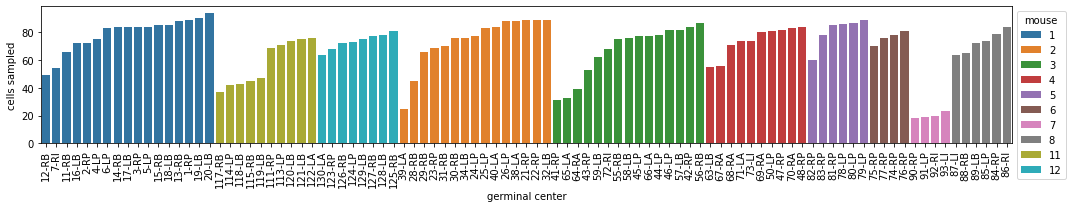

In [51]:
plt.figure(figsize=(15, 3))
ax = sns.barplot(data=df.sort_values(["mouse", "cells sampled"]), x="germinal center", y="cells sampled", hue="mouse",
                 hue_order=df.mouse.unique(),
                 dodge=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"{output_dir}/abundances.pdf")
plt.show()

## Plot tree shape stats in a scatter plot, and render some example trees
For each tree we render it colored by LBR, then by affinity, and by GVI

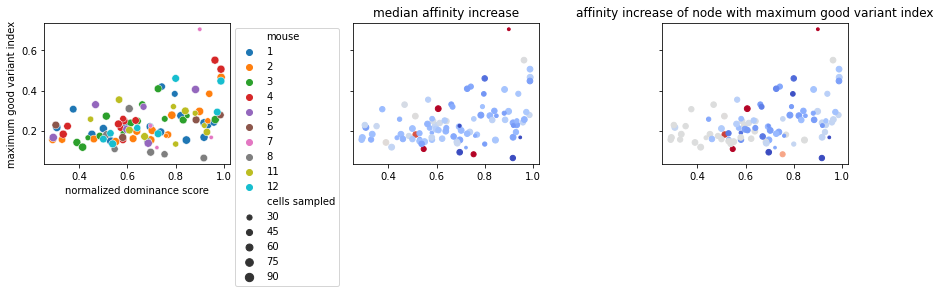

In [57]:
# LBR cmap
cmap = "viridis"
vmin = 0
vmax = max(node.LBR for tree in trees.values() for node in tree.tree.traverse())

# affinity cmap
cmap2 = "coolwarm_r"
vmin2 = -2
vmax2 = 2

# GVI cmap
cmap3 = "viridis"
vmin3 = min(node.GVI for tree in trees.values() for node in tree.tree.traverse())
vmax3 = max(node.GVI for tree in trees.values() for node in tree.tree.traverse())

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)
sns.scatterplot(data=df, x="normalized dominance score", y="maximum good variant index", hue="mouse", size="cells sampled",
                clip_on=False, ax=ax1)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
ax2.set_title("median affinity increase")
ax2.scatter(df["normalized dominance score"], df["maximum good variant index"], c=df["median affinity increase"], s=0.4 * df["cells sampled"],
                clip_on=False,
                cmap=cmap2, vmin=vmin2, vmax=vmax2)
ax3.set_title("affinity increase of node with maximum good variant index")
ax3.scatter(df["normalized dominance score"], df["maximum good variant index"], c=df["affinity increase of max GVI node"], s=0.4 * df["cells sampled"],
                clip_on=False,
                cmap=cmap2, vmin=vmin2, vmax=vmax2)
# ax1.set_yscale("log")
# ax2.set_yscale("log")
# ax3.set_yscale("log")
for i, row in df.iterrows():
    x, y = row[["normalized dominance score", "maximum good variant index"]]
    key = f"mouse{row.mouse}_GC{row['germinal center']}"
    colormap1 = trees[key].feature_colormap("LBR", vmin=vmin, vmax=vmax, scale="symlog", linthresh=1, cmap=cmap)
    for scale in (5, 20):
        trees[key].render(f"{output_dir}/trees/{key}.LBR.scale{scale}.svg", colormap=colormap1, scale=scale, branch_margin=-8)
    colormap2 = trees[key].feature_colormap("delta_bind_CGG_FVS_additive", vmin=vmin2, vmax=vmax2, cmap=cmap2)
    for scale in (5, 20):
        trees[key].render(f"{output_dir}/trees/{key}.binding.scale{scale}.svg", colormap=colormap2, scale=scale, branch_margin=-8)
    colormap3 = trees[key].feature_colormap("GVI", vmin=vmin3, vmax=vmax3, scale="linear", cmap=cmap3)
    for scale in (5, 20):
        trees[key].render(f"{output_dir}/trees/{key}.GVI.scale{scale}.svg", colormap=colormap3, scale=scale, branch_margin=-8)
    # if (x < 0.4 and y > 0.2) or (x == df["normalized dominance score"].min()) or (x > 0.95 and y < 0.08) or (y == df["maximum good variant index"].max()) or (np.abs(x - 0.67) == np.abs(df["normalized dominance score"] - 0.67).min()):
    #     print(f"mouse{row.mouse}, GC{row['germinal center']}")
    #     ax1.annotate(f"{row['germinal center'][:-3]}", [x, y], xytext=(0, -2), textcoords="offset points", ha="center", va="top")
    #     ax2.annotate(f"{row['germinal center'][:-3]}", [x, y], xytext=(0, -2), textcoords="offset points", ha="center", va="top")
    #     ax3.annotate(f"{row['germinal center'][:-3]}", [x, y], xytext=(0, -2), textcoords="offset points", ha="center", va="top")
    #     # display(trees[key].render("%%inline", colormap=colormap1, scale=20, branch_margin=-8))
    #     display(trees[key].render("%%inline", colormap=colormap2, scale=20, branch_margin=-8))
    #     display(trees[key].render("%%inline", colormap=colormap3, scale=20, branch_margin=-8))
plt.tight_layout()
plt.savefig(f"{output_dir}/scatter.pdf")
plt.show()

## Color bars for the tree colormaps

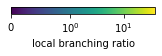

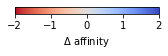

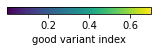

In [58]:
fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=SymLogNorm(linthresh=1, vmin=vmin, vmax=vmax)),
             orientation='horizontal',
             cax=cax,
             label="local branching ratio")
plt.savefig(f"{output_dir}/cbar1.pdf", bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap2, norm=Normalize(vmin=vmin2, vmax=vmax2)),
             orientation='horizontal',
             cax=cax,
             label=r"$\Delta$ affinity")
plt.savefig(f"{output_dir}/cbar2.pdf", bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap3, norm=Normalize(vmin=vmin3, vmax=vmax3)),
             orientation='horizontal',
             cax=cax,
             label="good variant index")
plt.savefig(f"{output_dir}/cbar3.pdf", bbox_inches="tight")
plt.show()

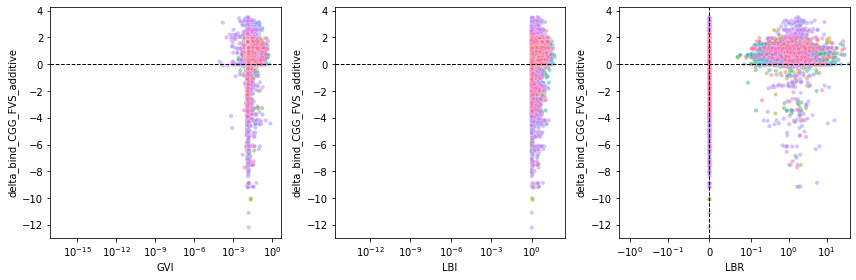

In [56]:
dat = []
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        dat.append([gc, node.GVI, node.LBI, node.LBR, node.delta_bind_CGG_FVS_additive])

df_nodes = pd.DataFrame(dat, columns=["germinal center", "GVI", "LBI", "LBR", "delta_bind_CGG_FVS_additive"])

plt.figure(figsize=(12, 4))

plt.subplot(131)
sns.scatterplot(data=df_nodes, x="GVI", y="delta_bind_CGG_FVS_additive", hue="germinal center", legend=False, alpha=0.5, size=.1)
plt.axhline(0, ls="--", c="k", lw=1)
plt.axvline(0, ls="--", c="k", lw=1)
plt.xscale("log")

plt.subplot(132)
sns.scatterplot(data=df_nodes, x="LBI", y="delta_bind_CGG_FVS_additive", hue="germinal center", legend=False, alpha=0.5, size=.1)
plt.axhline(0, ls="--", c="k", lw=1)
plt.axvline(0, ls="--", c="k", lw=1)
plt.xscale("log")

plt.subplot(133)
sns.scatterplot(data=df_nodes, x="LBR", y="delta_bind_CGG_FVS_additive", hue="germinal center", legend=False, alpha=0.5, size=.1)
plt.axhline(0, ls="--", c="k", lw=1)
plt.axvline(0, ls="--", c="k", lw=1)
plt.xscale("symlog", linthresh=.1)

plt.tight_layout()
plt.show()